# Pipeline for loading data and training a model

The pipeline for loading data and training model consists of the following steps:

1. Load data from the dataset folder source and a metadata CSV file. (replace with your directory if needed)
2. Preprocess the data by augmenting images and sanitizing metadata.
3. Split the data into training and validation sets.
4. Encode metadata using standard scaling for numerical features and one-hot encoding for categorical features.
5. Combine image and metadata inputs.
6. Build a convolutional neural network model with combined image and metadata input.
7. Train the model using the training data and hyperparameters. (replace with your hyperparameters if needed)
8. Evaluate the model on the test data.
9. Plot the training history, confusion matrix, prediction fractions, ROC curves, and Precision-Recall curves.
10. Save the best trained model to a file, also preserve hyperparameters used.

## Load data

In [2]:
from PIL import Image

folder1 = '../../data/HAM10000/HAM10000_images_part_1'
folder2 = '../../data/HAM10000/HAM10000_images_part_2'
destination_folder = '../../data/HAM10000/HAM10000_images'
metadata_file = '../../data/HAM10000/HAM10000_metadata.csv'
augmented_folder = '../../data/HAM10000/HAM10000_images_augmented'


def generate_image_id_list(metadata, num_samples=100):
    # Filter metadata to get unique dx values
    unique_dx = metadata['dx'].unique()

    # Initialize an empty dictionary to store image IDs for each dx
    image_id_dict = {}

    # Iterate through unique dx values
    for dx_value in unique_dx:
        # Filter metadata for current dx
        dx_metadata = metadata[metadata['dx'] == dx_value]

        # Get image IDs for the current dx
        image_ids = dx_metadata['image_id'].unique()

        # Ensure we have at least num_samples image IDs for this dx
        if len(image_ids) >= num_samples:
            # Randomly select num_samples unique image_id for this dx
            selected_image_ids = np.random.choice(image_ids, num_samples, replace=False)
        else:
            # If there are fewer than num_samples, select all of them
            selected_image_ids = image_ids

        # Store the selected image IDs for this dx
        image_id_dict[dx_value] = selected_image_ids

    return image_id_dict


def load_data(folder1, folder2, destination_folder, metadata_file, image_dimension=96):
    """
    Load data from two folders of images and a metadata CSV file.

    Parameters:
    - folder1: Path to the first folder of images.
    - folder2: Path to the second folder of images.
    - destination_folder: Path to the destination folder where merged images will be stored.
    - metadata_file: Path to the metadata CSV file containing image labels.
    - num_samples: Number of samples per class to include in the dataset (optional).

    Returns:
    - images: NumPy array of resized images.
    - labels: NumPy array of corresponding labels.
    - metadata: DataFrame containing metadata excluding the label column.
    """
    print(f'Loading data...')

    # Create destination folder
    if os.path.exists(destination_folder):
        shutil.rmtree(destination_folder)
    os.makedirs(destination_folder)

    # Load metadata
    metadata = pd.read_csv(metadata_file)
    metadata = metadata.drop_duplicates()

    # Check if num_samples is specified
    # if num_samples is not None:
    #     # Get unique dx values for sampling
    #     image_id_dict = generate_image_id_list(metadata, num_samples=num_samples)
    #     selected_image_ids = []
    #     for image_ids in image_id_dict.values():
    #         selected_image_ids.extend(image_ids)
    #     selected_image_ids = set(selected_image_ids)
    #
    #     # Filter metadata to include only selected image IDs
    #     metadata = metadata[metadata['image_id'].isin(selected_image_ids)]

    # Merge two folders from the original format
    for folder in [folder1, folder2]:
        for filename in os.listdir(folder):
            source = os.path.join(folder, filename)
            destination = os.path.join(destination_folder, filename)
            shutil.copy(source, destination)

    # Load images and compress them for efficient format
    images = []
    for index, row in metadata.iterrows():
        img_path = os.path.join(destination_folder, row['image_id'] + '.jpg')
        try:
            image = Image.open(img_path).convert('RGB')
            image = image.resize((image_dimension, image_dimension))
            images.append(np.array(image))
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

    images = np.array(images)

    print('Loaded!')
    return images, metadata


images, metadata = load_data(folder1, folder2, destination_folder, metadata_file, 96)

Loading data...
Loaded!


## Preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.image import resize
import os
import shutil

lesion_type_dict = {
    0: {'code': 'nv', 'name': 'Melanocytic nevi'},
    1: {'code': 'mel', 'name': 'Melanoma'},
    2: {'code': 'bkl', 'name': 'Benign keratosis-like lesions'},
    3: {'code': 'bcc', 'name': 'Basal cell carcinoma'},
    4: {'code': 'akiec', 'name': 'Actinic keratoses'},
    5: {'code': 'vasc', 'name': 'Vascular lesions'},
    6: {'code': 'df', 'name': 'Dermatofibroma'}
}


def augment_images(images, metadata, augmented_folder, batch_size=2, target_size=(28, 28)):
    """
    Augment images by applying various transformations and save them to a folder.

    Parameters:
    - images: NumPy array of images to be augmented.
    - metadata: DataFrame containing metadata of the images.
    - batch_size: Number of augmentations to be generated per image.
    - target_size: Tuple indicating the desired size of the augmented images.

    Returns:
    - all_images: NumPy array containing original and augmented images.
    - all_metadata: DataFrame containing metadata for original and augmented images.
    """

    datagen = ImageDataGenerator(
        preprocessing_function=lambda x: np.rot90(x, k=np.random.choice([1, 2, 3])),
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=(1, 1.2),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create the folder for augmented images if it does not exist
    if os.path.exists(augmented_folder):
        shutil.rmtree(augmented_folder)
    os.makedirs(augmented_folder)

    # DataFrames and lists to store augmented images and metadata
    augmented_metadata = pd.DataFrame()
    augmented_images = []

    # Augment each image
    for i in range(len(images)):
        image = images[i]
        image = img_to_array(image).reshape((1,) + image.shape)

        # Generate augmented images
        aug_iter = datagen.flow(image, batch_size=batch_size)
        aug_images = [next(aug_iter)[0] for _ in range(batch_size)]

        for j, aug_image in enumerate(aug_images):
            aug_image = aug_image.astype(np.uint8)

            # Resize the image to the target size
            aug_image = resize(aug_image, target_size)
            aug_image = aug_image.numpy().astype(np.uint8)

            img = array_to_img(aug_image)

            # Save augmented image
            aug_image_id = f"{metadata.iloc[i]['image_id']}_aug_{j}"
            img_path = os.path.join(augmented_folder, f"{aug_image_id}.jpg")
            img.save(img_path)

            # Append metadata for augmented image
            new_metadata = pd.DataFrame({
                'image_id': [aug_image_id],
                'lesion_id': [metadata.iloc[i]['lesion_id']],
                'dx': [metadata.iloc[i]['dx']],
                'dx_type': [metadata.iloc[i]['dx_type']],
                'age': [metadata.iloc[i]['age']],
                'sex': [metadata.iloc[i]['sex']],
                'localization': [metadata.iloc[i]['localization']]
            })
            augmented_metadata = pd.concat([augmented_metadata, new_metadata], ignore_index=True)

            augmented_images.append(aug_image)

    # Combine original and augmented data
    resized_images = np.array([resize(image, target_size).numpy().astype(np.uint8) for image in images])
    all_images = np.concatenate((resized_images, np.array(augmented_images)), axis=0)
    all_metadata = pd.concat([metadata, augmented_metadata], ignore_index=True)

    print('Augmented!')
    return all_images, all_metadata


def sanitize_data(metadata):
    """
    Clean metadata by filling missing values and drop redundant columns.

    Parameters:
    - metadata: DataFrame containing metadata of the images.
    """
    print('Sanitizing data...')

    # Drop redundant columns from learning standpoint
    metadata = metadata.drop(columns=['lesion_id', 'image_id'], errors='ignore')

    # Fill missing age with mean age
    metadata['age'] = metadata['age'].fillna(metadata['age'].mean())

    categorical_columns = ['dx_type', 'sex', 'localization']

    for col in categorical_columns:
        # Calculate the value counts and normalize to get probabilities
        value_counts = metadata[col].value_counts(normalize=True)

        # Generate random choices based on the probability distribution
        missing_indices = metadata[metadata[col].isna()].index
        random_choices = np.random.choice(value_counts.index, size=len(missing_indices), p=value_counts.values)

        # Fill missing values with the random choices
        metadata.loc[missing_indices, col] = random_choices

    print('Sanitized!')
    return metadata


def preprocess_data(images, metadata, augmented_folder):
    """
    Arranges preprocess steps into a pipeline.

    Parameters:
    - images: NumPy array of images to be preprocessed.
    - metadata: DataFrame containing metadata of the images.

    Returns:
    - images: NumPy array of preprocessed images.
    - metadata: DataFrame containing cleaned metadata.
    """
    print('Preprocessing data...')

    images, metadata = augment_images(images, metadata, augmented_folder)
    metadata = sanitize_data(metadata)

    print('Preprocessed!')
    return images, metadata


images, metadata = preprocess_data(images, metadata, augmented_folder='augmented_images')

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Preprocessing data...
Augmented!
Sanitizing data...
Sanitized!
Preprocessed!


## Train/test split

In [4]:
from scripts.preprocess_data import lesion_type_dict


def split_X(images, metadata, validation_split=0.2):
    """
    Split the dataset into training and validation sets.

    Parameters:
    - images: NumPy array of images.
    - metadata: DataFrame containing metadata.
    - validation_split: Fraction of the data to use for validation (default is 0.2).

    Returns:
    - (train_images, train_metadata): Training set of images and metadata.
    - (val_images, val_metadata): Validation set of images and metadata.
    """
    data_size = len(images)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    val_size = int(data_size * validation_split)
    train_indices, val_indices = indices[val_size:], indices[:val_size]

    train_images = images[train_indices]
    val_images = images[val_indices]

    train_metadata = metadata.iloc[train_indices].reset_index(drop=True)
    val_metadata = metadata.iloc[val_indices].reset_index(drop=True)

    return (train_images, train_metadata), (val_images, val_metadata)


def extract_labels(metadata):
    """
    Extract labels from metadata based on a predefined dictionary.

    Parameters:
    - metadata: DataFrame containing metadata with a 'dx' column.

    Returns:
    - labels: Series of labels mapped from the 'dx' column.
    """
    labels = metadata['dx'].map({v['code']: k for k, v in lesion_type_dict.items()})
    return labels


def split_data(images, metadata, validation_split=0.2):
    """
    Split the data into training and validation sets, extracting labels and dropping the 'dx' column.

    Parameters:
    - images: NumPy array of images.
    - metadata: DataFrame containing metadata with a 'dx' column.
    - validation_split: Fraction of the data to use for validation (default is 0.2).

    Returns:
    - (train_images, train_metadata): Training set of images and metadata without 'dx' column.
    - (val_images, val_metadata): Validation set of images and metadata without 'dx' column.
    - train_labels: Training labels extracted from 'dx' column.
    - val_labels: Validation labels extracted from 'dx' column.
    """
    print('Splitting data...')

    (train_images, train_metadata), (val_images, val_metadata) = split_X(images, metadata, validation_split)

    train_labels = extract_labels(train_metadata)
    val_labels = extract_labels(val_metadata)

    train_metadata = train_metadata.drop(columns=['dx'])
    val_metadata = val_metadata.drop(columns=['dx'])

    print('Split!')
    return (train_images, train_metadata), (val_images, val_metadata), train_labels, val_labels


train_X, test_X, train_Y, test_Y = split_data(images, metadata, validation_split=0.2)
train_images, train_metadata = train_X

Splitting data...
Split!


## Metadata encoding

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def encode_metadata(metadata, fit=True, encoder=None):
    """
    Transform the metadata using standard scaling for numerical features
    and one-hot encoding for categorical features.

    Parameters:
    - metadata: DataFrame containing metadata.
    - fit: Boolean indicating if the encoder should be fitted (True for training data).
    - encoder: Pre-fitted encoder (used if fit is False).

    Returns:
    - metadata_transformed: Transformed metadata as a NumPy array.
    - encoder: Fitted encoder (if fit is True).
    """

    if fit:
        categorical_features = ['dx_type', 'sex', 'localization']
        numeric_features = ['age']

        dx_type_categories = ['histo', 'consensus', 'confocal', 'follow_up']
        sex_categories = ['male', 'female', 'unknown']
        localization_categories = [
            'scalp', 'ear', 'face', 'back', 'trunk', 'chest', 'upper extremity',
            'abdomen', 'unknown', 'lower extremity', 'genital', 'neck', 'hand',
            'foot', 'acral'
        ]

        encoder = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(categories=[dx_type_categories, sex_categories, localization_categories],
                                      sparse_output=False), categorical_features)
            ])
        metadata_transformed = encoder.fit_transform(metadata)
    else:
        metadata_transformed = encoder.transform(metadata)

    print('Metadata transformed!')
    return metadata_transformed, encoder


transformed_train_metadata, encoder = encode_metadata(train_metadata, fit=True)

Metadata transformed!


## CNN

## Input combiner

In [6]:
def combine_inputs(images, metadata):
    """
    Combine flattened image data with transformed metadata.

    Parameters:
    - images: NumPy array of images.
    - metadata: NumPy array of transformed metadata.

    Returns:
    - combined_input: Combined input array.
    """
    # Flatten image data
    flattened_images = images.reshape((images.shape[0], -1))
    # Combine with metadata
    combined_input = np.concatenate([flattened_images, metadata], axis=1)

    print('Inputs combined!')
    return combined_input

## Model builder

In [22]:
from keras import Model
from tensorflow.python.ops.init_ops_v2 import he_normal
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ReLU, concatenate, Reshape, \
    BatchNormalization
from tensorflow.keras.optimizers import Adam


class ModelBuilder:
    def __init__(self):
        pass

    def build_model(self, image_shape, metadata_shape, num_classes, M=2, N=2, K=2, learning_rate=0.001):
        """
        Build a convolutional neural network model with combined image and metadata input.

        Parameters:
        - image_shape: Shape of the input images.
        - metadata_shape: Shape of the metadata input.
        - num_classes: Number of output classes.
        - M: Number of blocks of convolutional layers for image data.
        - N: Number of convolutional layers per block.
        - K: Number of fully connected layers for metadata.
        - learning_rate: Learning rate for the Adam optimizer.

        Returns:
        - model: Compiled Keras model.
        """

        combined_input = Input(shape=(np.prod(image_shape) + metadata_shape,), name='combined_input')
        
        # Split combined input into image and metadata parts
        image_input = combined_input[:, :np.prod(image_shape)]
        metadata_input = combined_input[:, np.prod(image_shape):]

        # Reshape the image input
        image_input = Reshape(image_shape)(image_input)

        x = image_input
        # Convolutional layers for image input
        for i in range(M):
            for _ in range(N):
                x = Conv2D(32 * (2 ** i), (3, 3), padding='same', kernel_initializer=he_normal())(x)
                x = BatchNormalization()(x)
                x = ReLU()(x)
            x = MaxPooling2D(pool_size=(2, 2))(x) # reduce image spatial dimensions

        x = Flatten()(x)

        # Metadata input
        y = metadata_input
        for _ in range(K):
            y = Dense(128)(y)
            y = BatchNormalization()(y)
            y = ReLU()(y)

        # Concatenate both paths
        combined = concatenate([x, y])

        # Final fully connected layers
        z = Dense(1024, kernel_initializer=he_normal())(
            combined)
        z = BatchNormalization()(z)
        z = ReLU()(z)

        z = Dense(num_classes, activation='softmax', kernel_initializer=he_normal())(z)

        model = Model(inputs=[image_input, metadata_input], outputs=z)

        # Compile model
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        return model

model_builder = ModelBuilder()

## CNN class definition

In [23]:
import time
from keras.src.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import joblib


class NeuralNetworkCNN:
    def __init__(self, labels, model_builder, validation_split=0.2, batch_size=32, epochs=10, images=None,
                 metadata=None):
        if isinstance(labels, pd.Series):
            labels = labels.values

        self.labels = labels
        self.validation_split = validation_split
        self.batch_size = batch_size
        self.model_builder = model_builder
        self.epochs = epochs
        self.images = images
        self.metadata = metadata

    def train_model(self, train_images, train_metadata, train_labels, val_images, val_metadata, val_labels,
                    hyperparameters):
        class_weights = compute_class_weight('balanced', classes=np.unique(self.labels), y=self.labels)
        class_weights = {i: class_weights[i] for i in range(len(class_weights))}

        model = self.model_builder.build_model(
            image_shape=self.images.shape[1:],
            metadata_shape=self.metadata.shape[1],
            num_classes=len(np.unique(self.labels)),
            M=hyperparameters['M'], N=hyperparameters['N'], K=hyperparameters['K'],
            learning_rate=hyperparameters['learning_rate'],
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
        callbacks = [early_stopping, reduce_lr]

        history = History()

        print("Starting training...")
        history = model.fit(
            [train_images, train_metadata],
            train_labels,
            epochs=hyperparameters['epochs'],
            validation_data=([val_images, val_metadata], val_labels),
            class_weight=class_weights,
            batch_size=hyperparameters['batch_size'],
            callbacks=callbacks,
            verbose=1
        )

        print("Network trained!")
        return model, history

    def grid_search(self, param_grid):
        best_score = float('-inf')
        best_params = None
        best_score = 0

        # Split the data once for validation
        train_images, val_images, train_metadata, val_metadata, train_labels, val_labels = train_test_split(
            self.images, self.metadata, self.labels, test_size=self.validation_split, stratify=self.labels)

        for params in param_grid:
            start_time = time.time()
            print(f"Training with parameters: {params}")
            model, history = self.train_model(train_images, train_metadata, train_labels, val_images, val_metadata,
                                              val_labels, params)
            val_acc = max(history.history['val_accuracy'])
            end_time = time.time()
            print(f"Time elapsed for this training session: {self.__format_time(end_time - start_time)}")
            print(f"Validation accuracy: {val_acc}")

            if val_acc > best_score:
                best_score = val_acc
                best_params = params
                best_model = model

                model_file = "cnn_" + str(best_score) + ".pkl"
                param_file = "cnn_" + str(best_score) + ".txt"
                joblib.dump(best_model, model_file)
                with open(param_file, "w") as f:
                    f.write(str(best_params))

        print("Best params found during grid search:", best_params)
        print("Training final model on the entire dataset...")

        # Training the final model on the entire dataset with the best found hyperparameters
        model, history = self.train_model(self.images, self.metadata, self.labels, self.images, self.metadata,
                                          self.labels, best_params)

        model_file = "cnn_final_" + str(best_score) + ".pkl"
        joblib.dump(model, model_file)

        with open("params_final.txt", "w") as f:
            f.write(str(best_params))

        return model, best_params, history

    def __format_time(self, seconds):
        mins, secs = divmod(seconds, 60)
        hrs, mins = divmod(mins, 60)
        return f'{int(hrs):02}:{int(mins):02}:{int(secs):02}'


## Model training

In [24]:
from itertools import product

# Define hyperparameter grid, you can add more hyperparameters to search - here are our best hyperparams that have been found.
param_grid = {
    'M': [2],
    'N': [4],
    'K': [2],
    'batch_size': [128],
    'learning_rate': [1e-3],
    'epochs': [30],
}

# Convert grid to list of dictionaries
param_combinations = [dict(zip(param_grid, v)) for v in product(*param_grid.values())]

cnn = NeuralNetworkCNN(
    images=train_images,
    metadata=transformed_train_metadata,
    labels=train_Y,
    model_builder=model_builder
)

best_model, best_params, history = cnn.grid_search(param_combinations)

Training with parameters: {'M': 2, 'N': 2, 'K': 2, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 30}
Starting training...
Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 272ms/step - accuracy: 0.5038 - loss: 1.6098 - val_accuracy: 0.6317 - val_loss: 1.1823 - learning_rate: 0.0010
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.7141 - loss: 0.7537 - val_accuracy: 0.6916 - val_loss: 0.7772 - learning_rate: 0.0010
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 45s 299ms/step - accuracy: 0.7411 - loss: 0.6133 - val_accuracy: 0.7356 - val_loss: 0.6715 - learning_rate: 0.0010
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.7741 - loss: 0.5017 - val_accuracy: 0.7130 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 49s 324ms/step - accuracy: 0.8006 - loss: 0.4062 - val_accuracy: 0.7772 - val_loss: 0.5873 - learning_rate: 0.0010
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 49s 326ms/step - accuracy: 0.8384 - loss: 0.2907 - val_a

## Model evaluation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def eval_model(model, test_images, test_metadata, test_labels):
    """
    Evaluate the performance of the trained model on the test data.

    Parameters:
    model: Trained keras model.
    test_images (np.ndarray): Array of test images.
    test_metadata (np.ndarray): Array of test metadata.
    test_labels (np.ndarray): Array of test labels.

    Returns:
    predicted_labels: Array of predicted labels by the model.
    """
    print("Evaluating model...")

    # Combine images and metadata
    combined_input = combine_inputs(test_images, test_metadata)

    # Predict labels for test data
    predictions = model.predict([test_images, test_metadata])
    predicted_labels = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, predicted_labels)

    # Generate classification report
    class_report = classification_report(test_labels, predicted_labels)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

    return predicted_labels, predictions, accuracy


test_images, test_metadata = test_X
test_labels, _ = encode_metadata(test_metadata, encoder=encoder, fit=False)

predicted_labels, predictions, accuracy = eval_model(best_model, test_images, test_labels, test_Y)

Metadata transformed!
Evaluating model...
Inputs combined!
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Accuracy: 0.8364

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4017
           1       0.59      0.64      0.62       709
           2       0.72      0.69      0.70       666
           3       0.67      0.64      0.66       294
           4       0.63      0.55      0.59       194
           5       0.96      0.84      0.90        82
           6       0.73      0.77      0.75        47

    accuracy                           0.84      6009
   macro avg       0.75      0.72      0.73      6009
weighted avg       0.84      0.84      0.84      6009


## Graphs

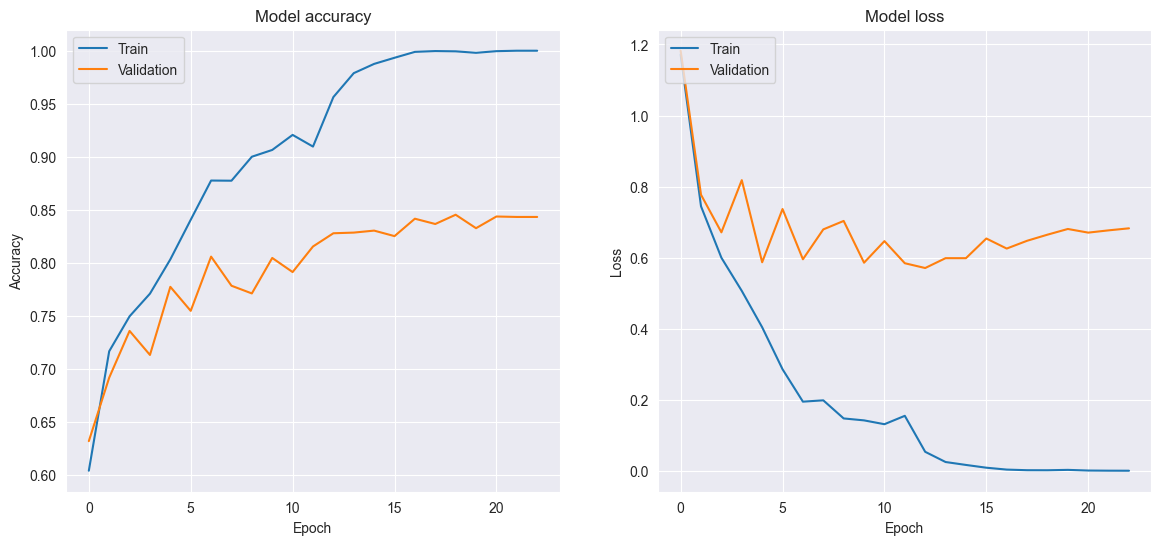

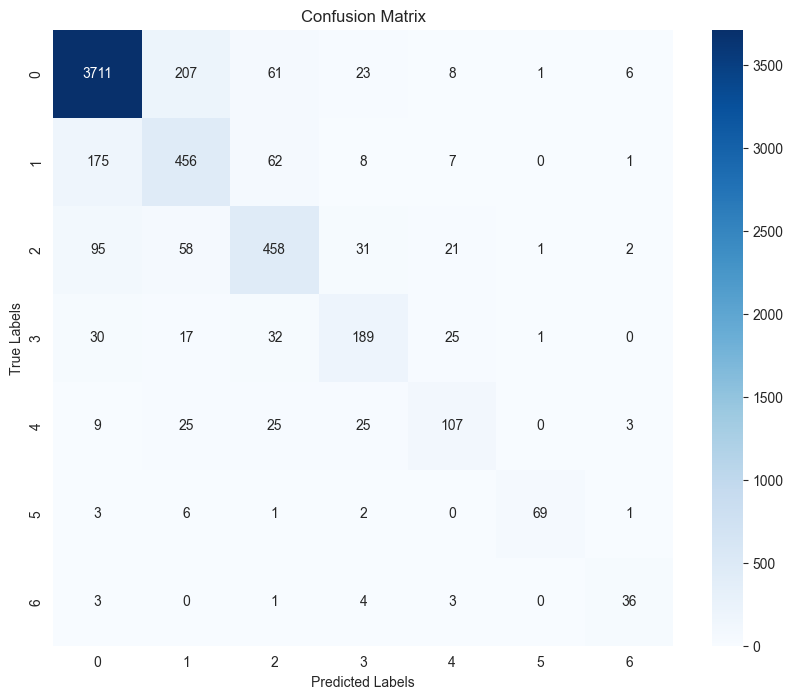

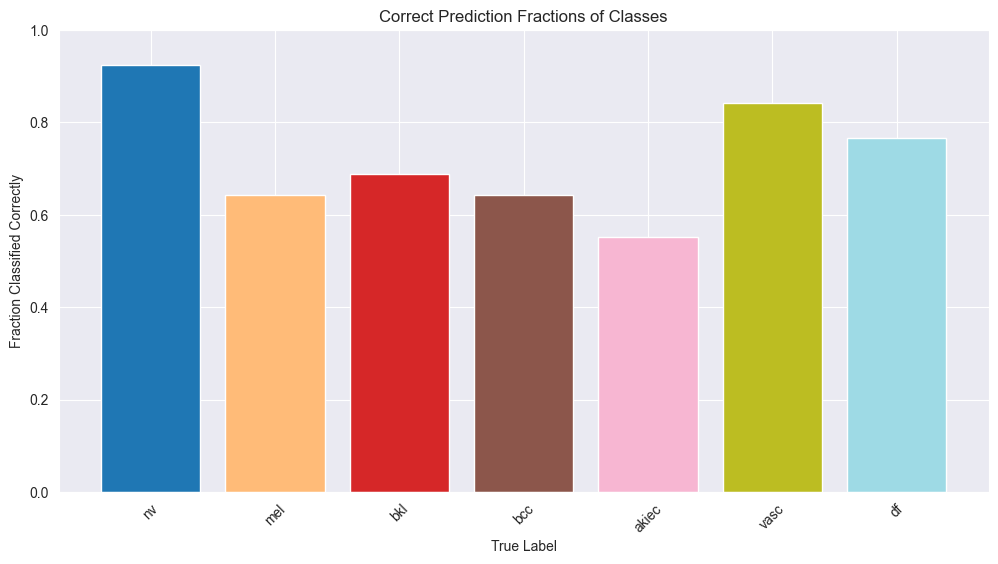

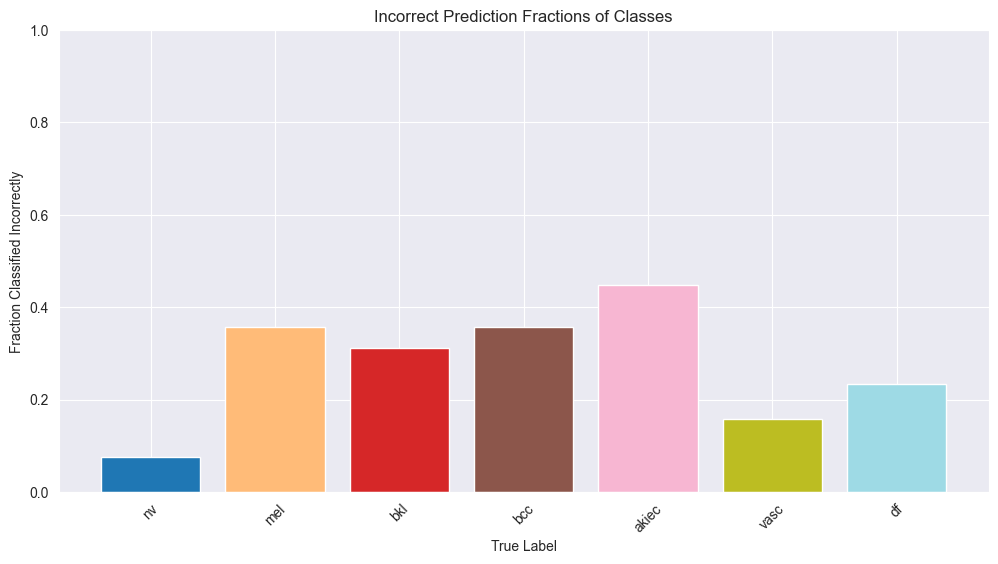

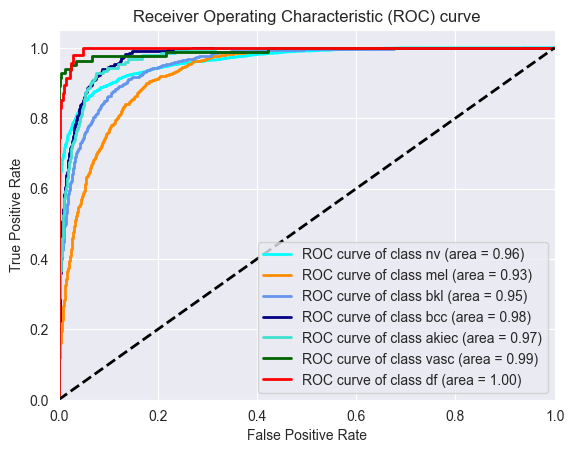

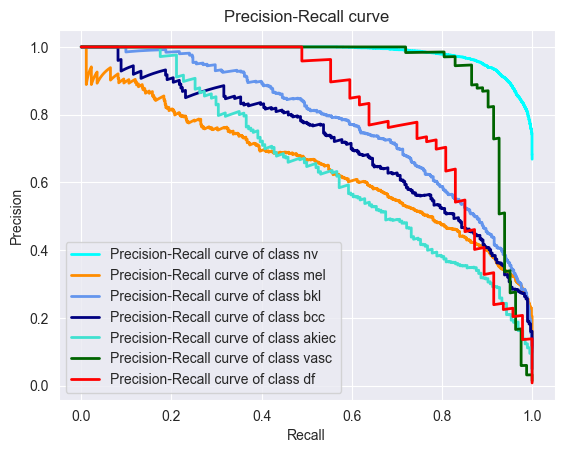

In [29]:
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, \
    precision_recall_curve


def plot_history(history):
    """
    Plot the training history.

    Parameters:
    history: History object returned from model.fit()
    """
    # Plotting the accuracy of the model for each epoch
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the loss of the model for each epoch
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


def plot_confusion_matrix(test_labels, predicted_labels):
    """
    Plot the confusion matrix.

    Parameters:
    test_labels: Array of true labels.
    predicted_labels: Array of predicted labels.
    """
    # Generate confusion matrix
    conf_matrix = confusion_matrix(test_labels, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels),
                yticklabels=np.unique(test_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return conf_matrix


def plot_prediction_fractions(conf_matrix):
    """
    Plot the fractions of correct and incorrect predictions for each class.

    Parameters:
    conf_matrix: Confusion matrix
    class_names: List of class names
    """

    # Calculate fractions of correct and incorrect predictions
    class_fraction_positive = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_fraction_negative = 1 - class_fraction_positive

    # Define colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(class_names)))

    # Plot correct prediction fractions
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(class_names)), class_fraction_positive, color=colors)
    plt.title('Correct Prediction Fractions of Classes')
    plt.xlabel('True Label')
    plt.ylabel('Fraction Classified Correctly')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.ylim(0, 1)
    plt.show()

    # Plot incorrect prediction fractions
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(class_names)), class_fraction_negative, color=colors)
    plt.title("Incorrect Prediction Fractions of Classes")
    plt.xlabel('True Label')
    plt.ylabel('Fraction Classified Incorrectly')
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.ylim(0, 1)
    plt.show()


def plot_roc_curves(test_labels, predictions):
    """
    Plot ROC curves for each class.

    Parameters:
    test_labels: Array of true labels.
    predictions: Array of predicted probabilities.
    class_names: List of class names.
    """
    lb = LabelBinarizer()
    lb.fit(test_labels)
    test_labels_binary = lb.transform(test_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binary[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'turquoise', 'darkgreen', 'red'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_precision_recall_curves(test_labels, predictions):
    """
    Plot Precision-Recall curves for each class.

    Parameters:
    test_labels: Array of true labels.
    predictions: Array of predicted probabilities.
    class_names: List of class names.
    """
    lb = LabelBinarizer()
    lb.fit(test_labels)
    test_labels_binary = lb.transform(test_labels)

    precision = dict()
    recall = dict()
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(test_labels_binary[:, i], predictions[:, i])

    # Plot Precision-Recall curve for each class
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'turquoise', 'darkgreen', 'red'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label='Precision-Recall curve of class {0}'
                       ''.format(class_names[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()


class_names = ["nv", "mel", "bkl", "bcc", "akiec", "vasc", "df"]
plot_history(history)
confusion_matrix = plot_confusion_matrix(test_Y, predicted_labels)
plot_prediction_fractions(confusion_matrix)
plot_roc_curves(test_Y, predictions)
plot_precision_recall_curves(test_Y, predictions)

In [ ]:
import joblib

joblib_file = "cnn_" + str(accuracy) + ".pkl"
joblib.dump(best_model, joblib_file)